In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('exchange_rate.csv')

In [7]:
df

,date,Ex_rate
0,01-01-1990 00:00,0.785500
1,02-01-1990 00:00,0.781800
2,03-01-1990 00:00,0.786700
3,04-01-1990 00:00,0.786000
4,05-01-1990 00:00,0.784900
...,...,...
7583,06-10-2010 00:00,0.718494
7584,07-10-2010 00:00,0.721839
7585,08-10-2010 00:00,0.723197
7586,09-10-2010 00:00,0.720825


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [9]:
df.isnull().sum()

date       0
Ex_rate    0
dtype: int64

In [10]:
df.shape

(7588, 2)

In [11]:
df['Ex_rate']

0       0.785500
1       0.781800
2       0.786700
3       0.786000
4       0.784900
          ...   
7583    0.718494
7584    0.721839
7585    0.723197
7586    0.720825
7587    0.720825
Name: Ex_rate, Length: 7588, dtype: float64

<Axes: ylabel='Frequency'>

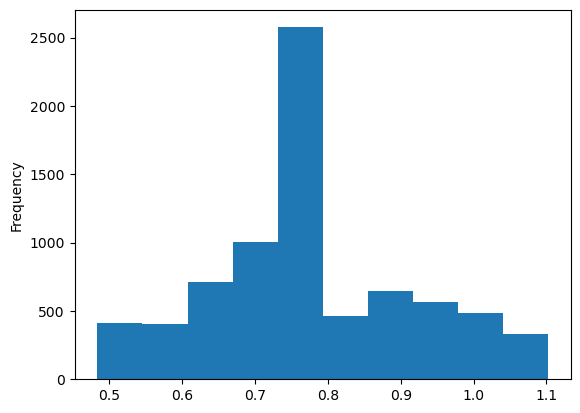

In [12]:
df['Ex_rate'].plot(kind = 'hist')

In [13]:
df['Ex_rate'].skew() # almost normally distributed

np.float64(0.2611267376737365)

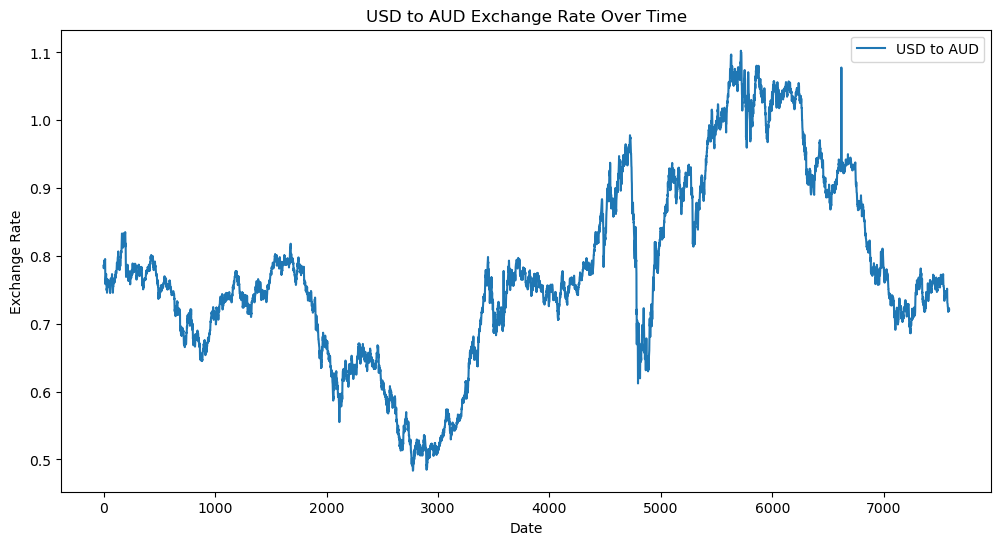

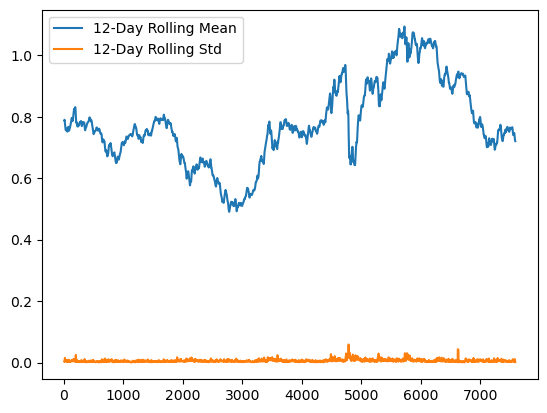

In [14]:
# Plot the exchange rate
plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='USD to AUD')
plt.title('USD to AUD Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

# Rolling mean and std to check trends and volatility
df['Ex_rate'].rolling(window=12).mean().plot(label='12-Day Rolling Mean')
df['Ex_rate'].rolling(window=12).std().plot(label='12-Day Rolling Std')
plt.legend()
plt.show()


In [15]:
# ARIMA MODEL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901


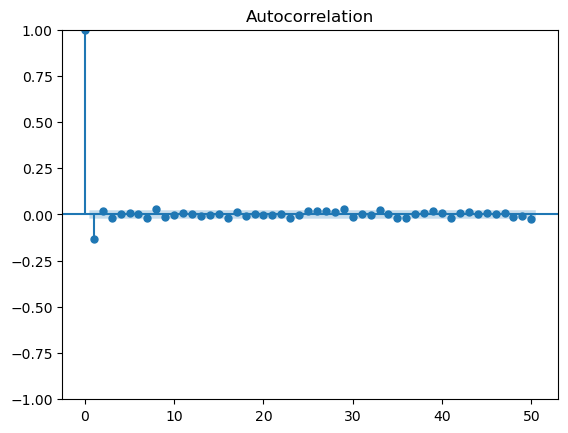

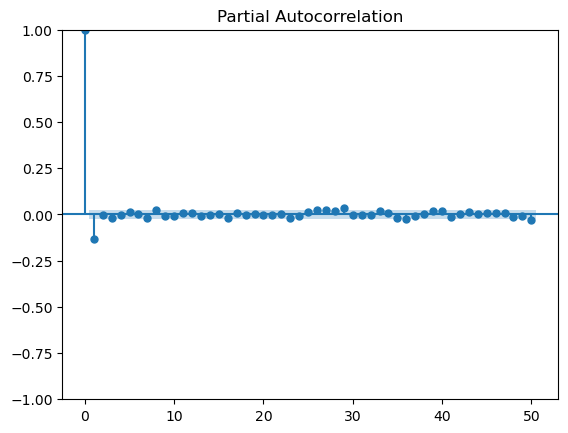

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Mon, 06 Oct 2025   AIC                         -56102.322
Time:                        14:36:06   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

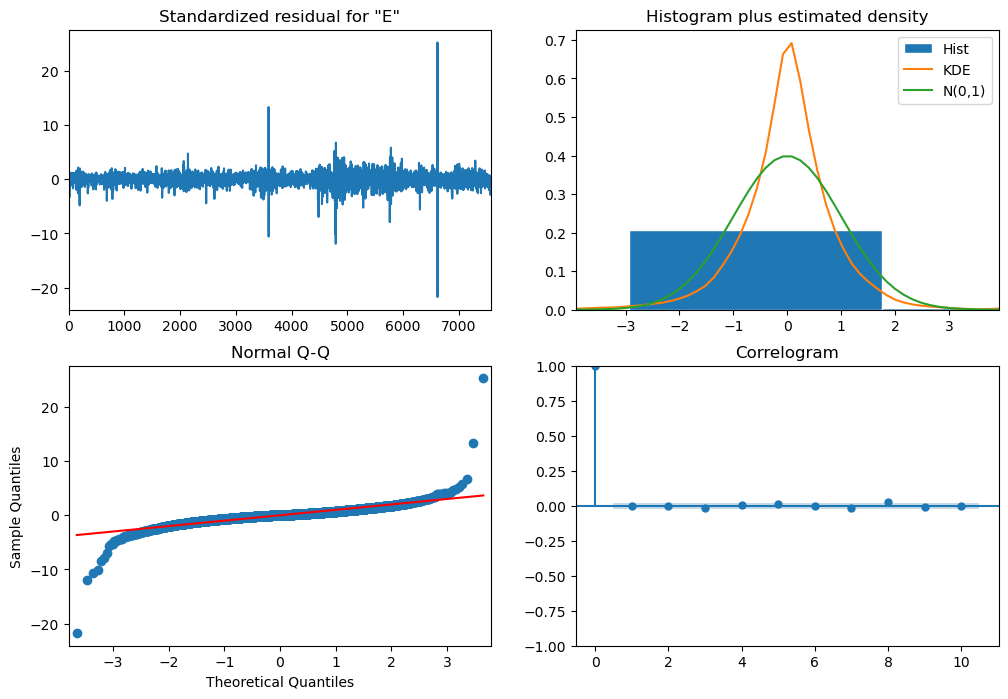

In [16]:

# Check stationarity
result = adfuller(df['Ex_rate'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If not stationary, take first difference
data_diff = df['Ex_rate'].diff().dropna()

# Plot ACF and PACF for parameter selection
plot_acf(data_diff, lags=50)
plot_pacf(data_diff, lags=50)
plt.show()

# Fit ARIMA model (example: ARIMA(1,1,1), adjust based on ACF/PACF)
arima_model = ARIMA(df['Ex_rate'], order=(1,1,1))
arima_result = arima_model.fit()
print(arima_result.summary())

# Diagnostics
arima_result.plot_diagnostics(figsize=(12,8))
plt.show()

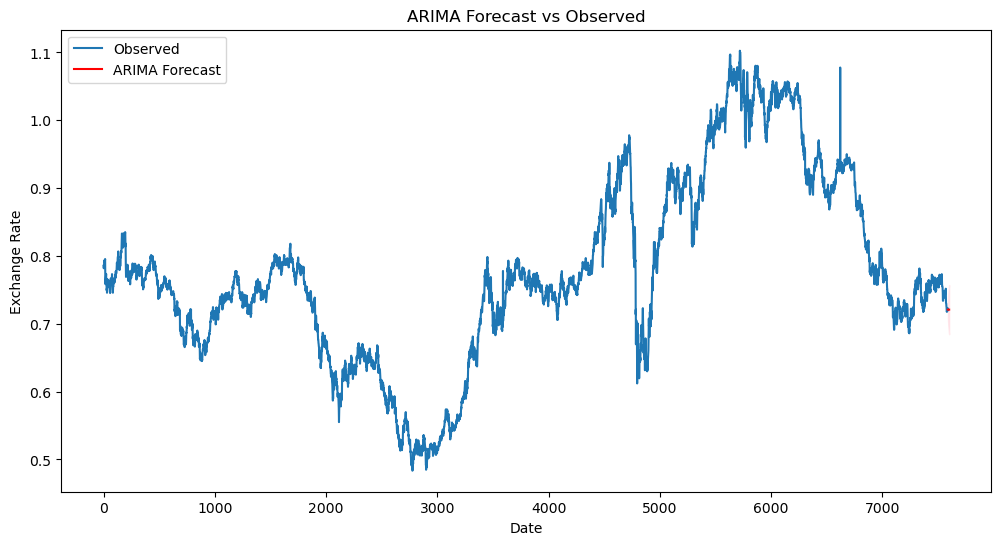

In [17]:
# EXPONENTIAL SMOOTHING
# Forecast next 12 periods
forecast_arima = arima_result.get_forecast(steps=12)
forecast_ci = forecast_arima.conf_int()

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_arima.predicted_mean, label='ARIMA Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1], color='pink', alpha=0.3)
plt.title('ARIMA Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.009
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.998
Seasonal Periods:                  None   Date:                 Mon, 06 Oct 2025
Box-Cox:                          False   Time:                         14:36:08
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8700406                alpha                 True
smoothing_trend             0.0000

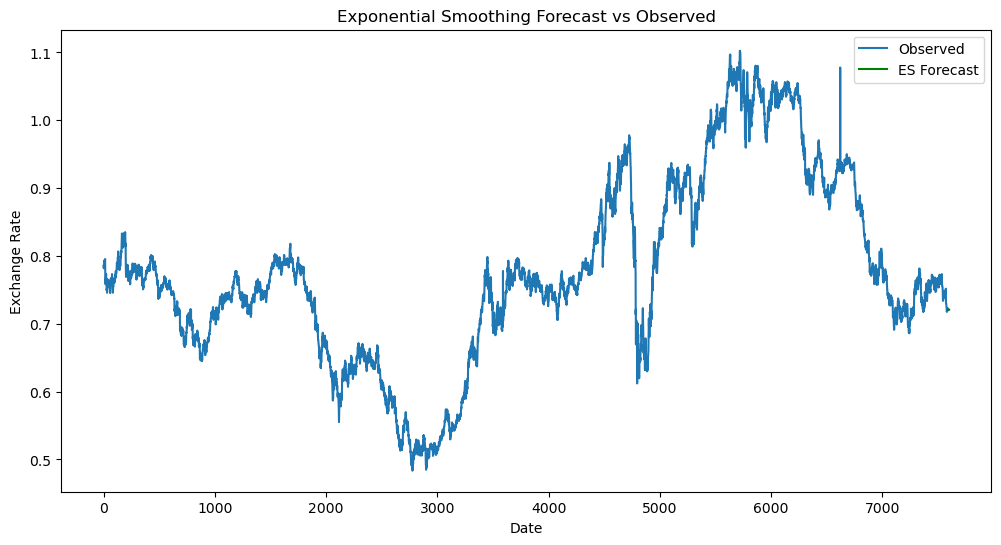

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Holt-Winters (additive trend, no seasonality)
es_model = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
es_result = es_model.fit()
print(es_result.summary())

# Forecast next 12 periods
forecast_es = es_result.forecast(12)

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_es, label='ES Forecast', color='green')
plt.title('Exponential Smoothing Forecast vs Observed')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [19]:
# EVALUATION & COMPARISON
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For demonstration, compare last 12 actual points with forecast (if available)
# Here using last 12 points from data as y_true
y_true = df['Ex_rate'][-12:]
y_pred_arima = forecast_arima.predicted_mean
y_pred_es = forecast_es

def safe_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Filter out any zero values to avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Ensure forecasts are aligned with y_true
y_pred_arima_aligned = y_pred_arima[-len(y_true):]
y_pred_es_aligned = y_pred_es[-len(y_true):]

# ARIMA metrics
print("ARIMA MAE:", mean_absolute_error(y_true, y_pred_arima_aligned))
print("ARIMA RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_arima_aligned)))
print("ARIMA MAPE:", safe_mape(y_true, y_pred_arima_aligned))

# Exponential Smoothing metrics
print("ES MAE:", mean_absolute_error(y_true, y_pred_es_aligned))
print("ES RMSE:", np.sqrt(mean_squared_error(y_true, y_pred_es_aligned)))
print("ES MAPE:", safe_mape(y_true, y_pred_es_aligned))

ARIMA MAE: 0.0016644924340379526
ARIMA RMSE: 0.002000358073451703
ARIMA MAPE: 0.23102311435756573
ES MAE: 0.0016726201414130892
ES RMSE: 0.001997196833238148
ES MAPE: 0.23214730630419525


In [37]:
import warnings
import itertools
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Very small ranges for short series
p = [0, 1]
d = [0, 1]
q = [0, 1]

best_aic = float('inf')
best_order = None

for order in itertools.product(p, d, q):
    try:
        model = ARIMA(df['Ex_rate'], order=order)
        result = model.fit()
        if result.aic < best_aic:
            best_aic = result.aic
            best_order = order
    except:
        continue

if best_order is None:
    print("ARIMA not feasible on this dataset. Using Exponential Smoothing instead.")
else:
    print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
    # Fit final model
    model = ARIMA(df['Ex_rate'], order=best_order)
    fit = model.fit()
    forecast = fit.get_forecast(steps=5)
    print(forecast.predicted_mean)


Best ARIMA order: (1, 1, 0) with AIC: -56104.318870183706
7588    0.720825
7589    0.720825
7590    0.720825
7591    0.720825
7592    0.720825
Name: predicted_mean, dtype: float64


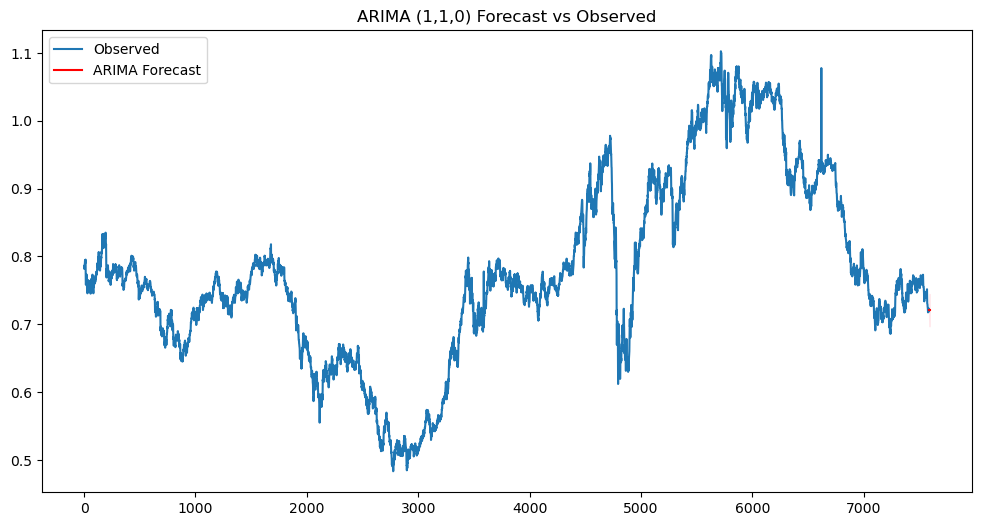

In [38]:
import matplotlib.pyplot as plt

forecast = fit.get_forecast(steps=5)
forecast_ci = forecast.conf_int()

plt.figure(figsize=(12,6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast.predicted_mean, label='ARIMA Forecast', color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1],
                 color='pink', alpha=0.3)
plt.legend()
plt.title('ARIMA (1,1,0) Forecast vs Observed')
plt.show()


In [39]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_true = df['Ex_rate'][-5:]  # replace with actual test values
y_pred = forecast.predicted_mean

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)


MAE: 0.0011433999999999945
RMSE: 0.0015548724063407886
MAPE: nan
